# 8.2  Exercise

Amelia Farrell

DSC520

1/31/22


In [ ]:
# Loading packages needed
%matplotlib inline

import numpy as np
import pandas as pd

import thinkstats2
import thinkplot

from thinkstats2 import Mean, MeanVar, Var, Std, Cov

In [ ]:
# Data
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

ages = live.agepreg
weights = live.totalwgt_lb

In [ ]:
# Creating Permutation test function. To compute the p-value of an observed difference in means
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [ ]:
# Creating function to test if an observed correlation is statistically significant (running a permutation test with a different test statistic).
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [ ]:
# Creating function for conducting a Chi-square test of pregnancy length
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

# Chapter 9

## Page 114: 9-1 
(As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real…)

Running tests using different subsets of the NSFG data to see what happens to the p-values as sample size decreases.

In [ ]:
def RunTests(live, iters=1000):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]
   # data = firsts.prglngth.values, others.prglngth.values
    #ht = DiffMeansPermute(data)

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

RunTests(live)

9148	0.18	0.00	0.00	0.00


In [ ]:
# Running our test using different sample sizes
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

9148	0.17	0.00	0.00	0.00
4574	0.13	0.00	0.00	0.00
2287	0.02	0.11	0.00	0.00
1143	0.02	0.26	0.01	0.00
571	0.07	0.65	0.13	0.02
285	0.28	0.18	0.10	0.12
142	0.27	0.77	0.61	0.01


Based if the above test we can see that as n decreases (from 9148 to 142) the the p-values also decrease. This is somthing that we need to be very aware of when reading studies. P-values can appear more significant than they truly are just by adding more data points.

# Chapter 10

## Page 128: 10-1
(Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height…)

In [ ]:
# Creating a function to compute the mean, standard error, and 90% confidence interval.
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [ ]:
# Reading the BRFSS data and extract heights and log weights.
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [ ]:
# Estimating the intercept and slope.
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163917626, 0.005281454169418102)

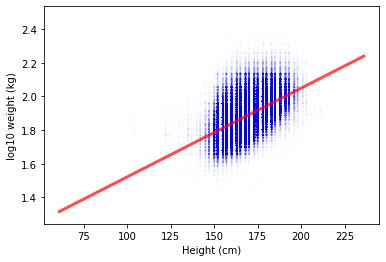

In [ ]:
# Creating a scatter plot to show the data points and fitted line.
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

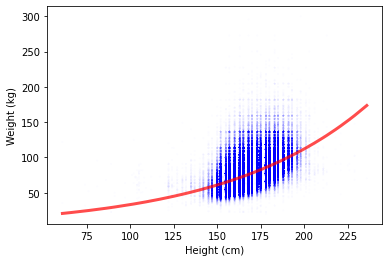

In [ ]:
# Creating another scatter plot with the inverse transform to show the data points on a linear scale.
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

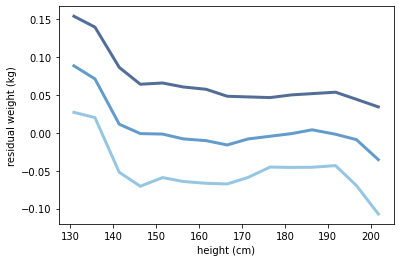

In [ ]:
# Plotting the percentiles of the residuals.

res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

The above plot showing the percentiles of the residuals, shows relatively consistant lines from 140 to 190. This indicates that the relationship is linear. Since the lines are also parallel to one another, this means that the variance of the residuals is also consistant.

In [ ]:
# Running the correlation coefficient between hight and log_weights
cc = thinkstats2.Corr(heights, log_weights)

# Running the correlation coefficient of determination.
r2 = thinkstats2.CoefDetermination(log_weights, res)

# Does cc = r2?
e = cc**2 - r2

# Standard deviation of log_weights
sd = thinkstats2.Std(log_weights)

# Standard deviation of residuals
sdr = thinkstats2.Std(res)

# Calculating how height effects RMSE
effect = 1 - sdr / sd

print("correlation coefficient:", cc)
print("R-squared:",r2)
print("Are they equal?:",e)
print("Standard deviation:",sd)
print("Standard deviation of residuals:",sdr)
print("How much height effects RMSE:",effect)

correlation coefficient: 0.5317282605983583
R-squared: 0.28273494311894365
Are they equal?: 1.199040866595169e-14
Standard deviation: 0.10320725030004982
Standard deviation of residuals: 0.08740777080416141
How much height effects RMSE: 0.1530849765879363


In [ ]:
# Using resampling to compute sampling distributions for inter and slope.
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

{'xscale': 'linear', 'yscale': 'linear'}

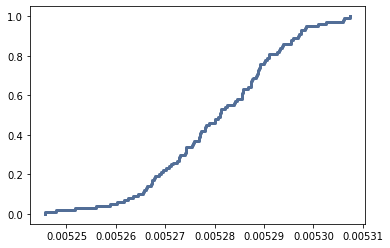

In [ ]:
# Plot sampling slope.
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [ ]:
# p-value of the slope
pvalue = cdf[0]

# 90% confidence interval of slope.
ci = cdf.Percentile(5), cdf.Percentile(95)

# mean of sampling distribution.
meansd = thinkstats2.Mean(slopes)

# standard deviation of sampling distribution
sdsd = thinkstats2.Std(slopes)

print("P-value:", pvalue)
print("90% confidence interval:", cc)
print("Mean:", cc)
print("Standard Deviation:", cc)

P-value: 0
90% confidence interval: 0.5317282605983583
Mean: 0.5317282605983583
Standard Deviation: 0.5317282605983583


In [ ]:
# Creating function to aid with calculation below
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [ ]:
# Resampling rows without weights
newsample_noweight = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(newsample_noweight)


mean, SE, CI 168.95741860183105 0.017506982800941814 (168.92795680995977, 168.98312415368136)


In [ ]:
# Resample rows with weights
sample_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(sample_weighted)

mean, SE, CI 170.4945228531296 0.01854917801871439 (170.45792659512117, 170.5277061985893)


Based off the above, how much does correct weighting affect the estimates? It affects it by almost 2 cm. If we look at the sampling weights we can see that the difference is greater than the sampling error.